## Calculate ERPs

In [2]:
#Importing files and modules

import numpy as np
import matplotlib.pyplot as plt
from os import path
%matplotlib notebook
from brainpipe.system import study
from brainpipe.visual import *
from brainpipe.statistics import *
from mne.baseline import rescale
from mne.filter import filter_data

## User variables

In [6]:
filename = 'MICP_E1E2_concat_allfilter1.npz'
low_pass_filter = 10.
sf = 512.
norm_mode = 'mean' #'ratio' 'mean' 'percent' 
elec = 5
baseline = [717 , 768]
data_to_use = [768, 1536]
n_perm = 200

# Load and prepare data
## Load file

In [14]:
st = study('Olfacto')
path_data = path.join (st.path, 'database/TS_E_all_cond_by_block_trigs_th30_400art/')

# Data file for 1 subject
data_all = np.load(path.join(path_data, filename))

# Load data and channels :
data, channel = data_all['x'], [data_all['channel'][i][0] for i in range(len(data_all['channel']))]
label = [data_all['label'][i][0] for i in range(len(data_all['label']))]

# Select data for one elec + name :
data_elec = data[elec,:,:]
ntrials = len(data_elec[2])
print ('\nOriginal data : ', data.shape, 'Channel : ', channel[elec], 'Label : ', label[elec], 'N_trials :', ntrials, 'One elec shape : ', data_elec.shape)

#Filter data for one elec :
data = np.array(data_elec, dtype='float64')
data_to_filter = np.swapaxes(data, 0, 1)
filtered_data = filter_data(data_to_filter, sfreq=512, l_freq=None, h_freq=low_pass_filter, method='fir', phase='zero-double')
filtered_data = np.swapaxes(filtered_data, 0, 1)
print ('Size of filtered data:', filtered_data.shape,)

#Average the data across trials for one electrode :
mean_filtered_data = np.mean(filtered_data, axis=1)
mean_data_elec = np.mean(data_elec, axis=1)
print ('Size of the filtered mean data: ', mean_filtered_data.shape, 'Size of the meaned data:',mean_data_elec.shape)

-> Olfacto loaded

Original data :  (122, 2304, 81) Channel :  a'6 Label :  WM-MTG N_trials : 81 One elec shape :  (2304, 81)
Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 1352 samples (2.641 sec) selected
Size of filtered data: (2304, 81)
Size of the filtered mean data:  (2304,) Size of the meaned data: (2304,)


## Normalize ERP

In [20]:
#Normalize the ERP
times = np.arange(mean_data_elec.shape[0])
print ('time points : ', times.shape)
norm_filtered_data = rescale(mean_filtered_data, times=times, baseline=baseline, mode=norm_mode)
norm_data = rescale(mean_data_elec, times=times, baseline=baseline, mode=norm_mode,)
print ('Size norm & filtered data : ', norm_filtered_data.shape, 'Size norm raw data : ', norm_data.shape,)

time points :  (2304,)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Size norm & filtered data :  (2304,) Size norm raw data :  (2304,)


# Compute stats
## Select data
Calcul des stats sur des données non-moyénnées et à travers la dimension trial

In [37]:
# Define a range vector for the baseline and data :
baseline_range = range(baseline[0], baseline[1])
data_range = range(data_to_use[0], data_to_use[1])

# Now, get the baseline and data from the RAW data :
#baseline_tr = data_elec[baseline_range, :]
#data_elec_tr = data_elec[data_range, :]

#Get the baseline and data from the FILTERED data :
baseline_tr = filtered_data[baseline_range, :]
data_elec_tr = filtered_data[data_range, :]

# Mean the baseline across time (increase consistency) :
baseline_tr = baseline_tr.mean(0)[np.newaxis, ...]

print('-> Shape of the baseline : ', baseline_tr.shape,' and the selected data :', data_elec_tr.shape)

-> Shape of the baseline :  (1, 81)  and the selected data : (768, 81)


## Prepare data (insure compatibility with the perm_swap function)
pour fonctionner, perm_swap demande à ce que les deux matrices a et b aient la même taille. Donc on va prendre la baseline et la répétée autant de fois qu'il y a de points temporels.

In [38]:
# Repeat the baseline :
baseline_tr_rep = np.tile(baseline_tr, (data_elec_tr.shape[0], 1))
print('-> Shape of repeated baseline :', baseline_tr_rep.shape)

-> Shape of repeated baseline : (768, 81)


## Compute the stats using permutations

In [39]:
# Swap RAW data and baseline across trials (dim 1) :
perm_data = perm_swap(baseline_tr_rep, data_elec_tr, axis=1, n_perm=n_perm)[0]
print('-> Shape of permuted data / baseline : ', perm_data.shape)

# Take the mean across time :
perm_data_raw = perm_data.mean(2)
print('-> Shape of meaned permuted data / baseline : ', perm_data_raw.shape)

# Get p-values from the permuted data :
p_vals_raw = perm_2pvalue(data_elec_tr.mean(1), perm_data_raw, n_perm=n_perm, threshold=None, tail=2)
print('-> Shape of non-corrected p-values : ', p_vals_raw.shape)

-> Shape of permuted data / baseline :  (200, 768, 81)
-> Shape of meaned permuted data / baseline :  (200, 768)
-> Shape of non-corrected p-values :  (768,)


## Correction of p-values for multiple comparison (across time)

In [40]:
# Correct across time :
perm_raw_corr = maxstat(perm_data, axis=2)[..., 0]
print('-> Shape of maxstat perm : ', perm_raw_corr.shape)

# Get p-values from the permuted data :
p_vals_raw_corr = perm_2pvalue(data_elec_tr.mean(1), perm_raw_corr, n_perm=n_perm, threshold=None, tail=2)
print('-> Shape of corrected p-values : ', p_vals_raw_corr.shape)

# Test if there's significant p-values after multiplt comparison :
print('-> Significant p-values after mutiple comparison? ', p_vals_raw_corr.min() <= 0.05)

-> Shape of maxstat perm :  (200, 768)
-> Shape of corrected p-values :  (768,)
-> Significant p-values after mutiple comparison?  False


# Plot
## Prepare plotting variables

In [41]:
# Data to plot :
data_to_plot = norm_data[range(baseline[0], data_to_use[1])]
print('-> Shape of data to plot : ', data_to_plot.shape)
filtered_data_to_plot = norm_filtered_data[range(baseline[0], data_to_use[1])]
print('-> Shape of filtered data to plot : ', data_to_plot.shape)

# Time vector :
times_plot = 1000 * np.arange((baseline[0] - baseline[1]), data_to_plot.shape[0]-baseline[1] + baseline[0],) / sf
print('-> Shape of time vector : ', times_plot.shape)


# P-values to plot :
p_vals_raw_to_plot = np.insert(p_vals_raw, 0, 10 * np.ones((baseline[1] - baseline[0],)))
p_vals_raw_corr_to_plot = np.insert(p_vals_raw_corr, 0, 10 * np.ones((baseline[1] - baseline[0],)))
print('-> Shape of p-values to plot :', p_vals_raw_to_plot.shape, p_vals_raw_corr_to_plot.shape)

-> Shape of data to plot :  (819,)
-> Shape of filtered data to plot :  (819,)
-> Shape of time vector :  (819,)
-> Shape of p-values to plot : (819,) (819,)


## Plots stats and ERPs

<IPython.core.display.Javascript object>


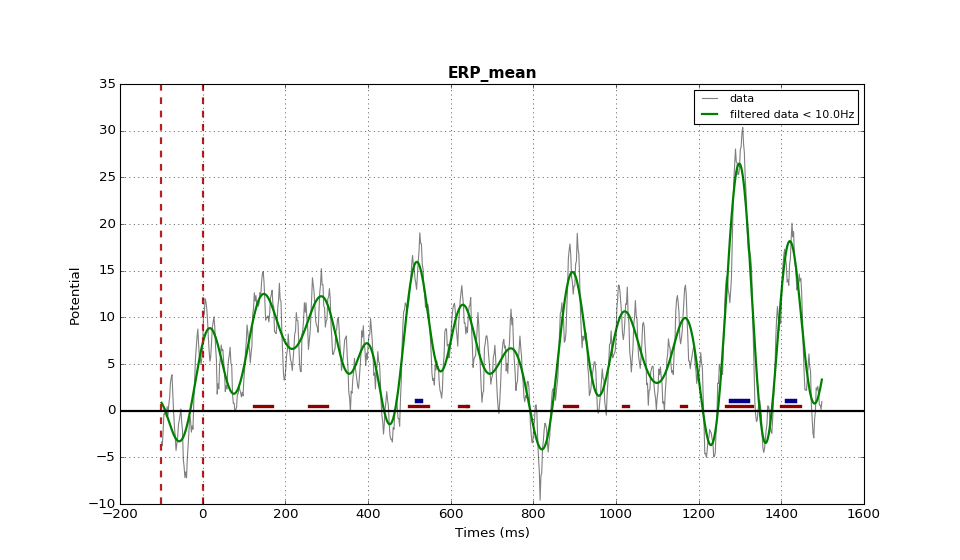

In [42]:
#Plot the ERP data and filtered data
fig = plt.figure(0, figsize=(12, 7))
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('ERP_'+norm_mode, fontsize=14, fontweight='bold')
ax.set_xlabel('Times (ms)', fontsize=12)
ax.set_ylabel('Potential', fontsize=12)
#BorderPlot(times_plot, filtered_data_to_plot, kind='sem', color='', alpha=0.2, linewidth=2, ncol=1, legend='filtered data < '+str(low_pass_filter)+'Hz')

# =================== PLOT DATA ===================
plt.plot(times_plot, data_to_plot, '#808080', linewidth=1, label='data')
plt.plot(times_plot, filtered_data_to_plot, 'g-', linewidth=2, label='filtered data < '+str(low_pass_filter)+'Hz')
lines = (-100, 0) #time vector is in ms
addPval(plt.gca(), p_vals_raw_to_plot, p=0.05, x=times_plot, y=0.5, color='darkred', lw=3)
addPval(plt.gca(), p_vals_raw_to_plot, p=0.01, x=times_plot, y=1, color='darkblue', lw=4)
addPval(plt.gca(), p_vals_raw_corr_to_plot, p=0.05, x=times_plot, y=2, color='red', lw=3)
addPval(plt.gca(), p_vals_raw_corr_to_plot, p=0.01, x=times_plot, y=3, color='dodgerblue', lw=4)
#addPval(plt.gca(), p_vals_filt_to_plot, p=0.05, x=times_plot, y=2, color='red', lw=3)
#addPval(plt.gca(), p_vals_filt_to_plot, p=0.01, x=times_plot, y=3, color='dodgerblue', lw=4)
addLines(plt.gca(), vLines=lines, vColor=['firebrick']*2, vWidth=[2]*2, hLines=[0], hColor=['#000000'], hWidth=[2])
plt.grid()
plt.legend(fontsize='small')
plt.show()